<a href="https://colab.research.google.com/github/BagusRezky/Machine-Learning/blob/main/10%20-%20RNN/Praktikum1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
tfds.disable_progress_bar()

In [2]:
def plot_graphs(history, metric):

  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Carlos Mencia continually, violently, hatefully screaming "B**ch!" at women is like screaming "N**ger!" at black people, except it\'s worse. Remember, the B word, unlike the N word, is the only pejorative term that is still associated on a daily basis with violence. "B**ch!" is the last thing women hear before they are raped, beaten, or murdered. This guy is perpetuating violence by hatefully using the language of violence. Sounds like he may be a gay guy trying to cover by woman-bashing, so that he will sound like a hetero. And how about all the Nazi white guys in his audience giving the fascist salutes while their stupid little bimbo white women whimper tee hee hee at their side, clearly terrified to protest this tidal wave of woman-hating. Tee hee hee. Bet Mencia doesn\'t believe or support free speech for THEM! Come on, Carlos \xc2\x96 do you want women to have the free speech to b**ch-slap you as loudly and violently and big-mouthed as you do, or do you think "free spee

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  1,   1,   1, ...,   0,   0,   0],
       [ 11,   7,   4, ...,   0,   0,   0],
       [287, 390,  16, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Carlos Mencia continually, violently, hatefully screaming "B**ch!" at women is like screaming "N**ger!" at black people, except it\'s worse. Remember, the B word, unlike the N word, is the only pejorative term that is still associated on a daily basis with violence. "B**ch!" is the last thing women hear before they are raped, beaten, or murdered. This guy is perpetuating violence by hatefully using the language of violence. Sounds like he may be a gay guy trying to cover by woman-bashing, so that he will sound like a hetero. And how about all the Nazi white guys in his audience giving the fascist salutes while their stupid little bimbo white women whimper tee hee hee at their side, clearly terrified to protest this tidal wave of woman-hating. Tee hee hee. Bet Mencia doesn\'t believe or support free speech for THEM! Come on, Carlos \xc2\x96 do you want women to have the free speech to b**ch-slap you as loudly and violently and big-mouthed as you do, or do you think "free sp

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[0.00868952]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 63ms/step
[0.00868952]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
391/391 [==============================] - 56s 116ms/step - loss: 0.6630 - accuracy: 0.5395 - val_loss: 0.5813 - val_accuracy: 0.7167
Epoch 2/10
391/391 [==============================] - 30s 75ms/step - loss: 0.4243 - accuracy: 0.8008 - val_loss: 0.3841 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 29s 73ms/step - loss: 0.3539 - accuracy: 0.8439 - val_loss: 0.3482 - val_accuracy: 0.8438
Epoch 4/10
391/391 [==============================] - 28s 70ms/step - loss: 0.3267 - accuracy: 0.8599 - val_loss: 0.3310 - val_accuracy: 0.8536
Epoch 5/10
391/391 [==============================] - 29s 73ms/step - loss: 0.3139 - accuracy: 0.8648 - val_loss: 0.3326 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3064 - accuracy: 0.8686 - val_loss: 0.3301 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3020 - accuracy: 0.8713 - val_loss: 0.3333 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 43ms/step - loss: 0.3156 - accuracy: 0.8534
Test Loss: 0.3156370520591736
Test Accuracy: 0.8533999919891357


(0.0, 0.6813680589199066)

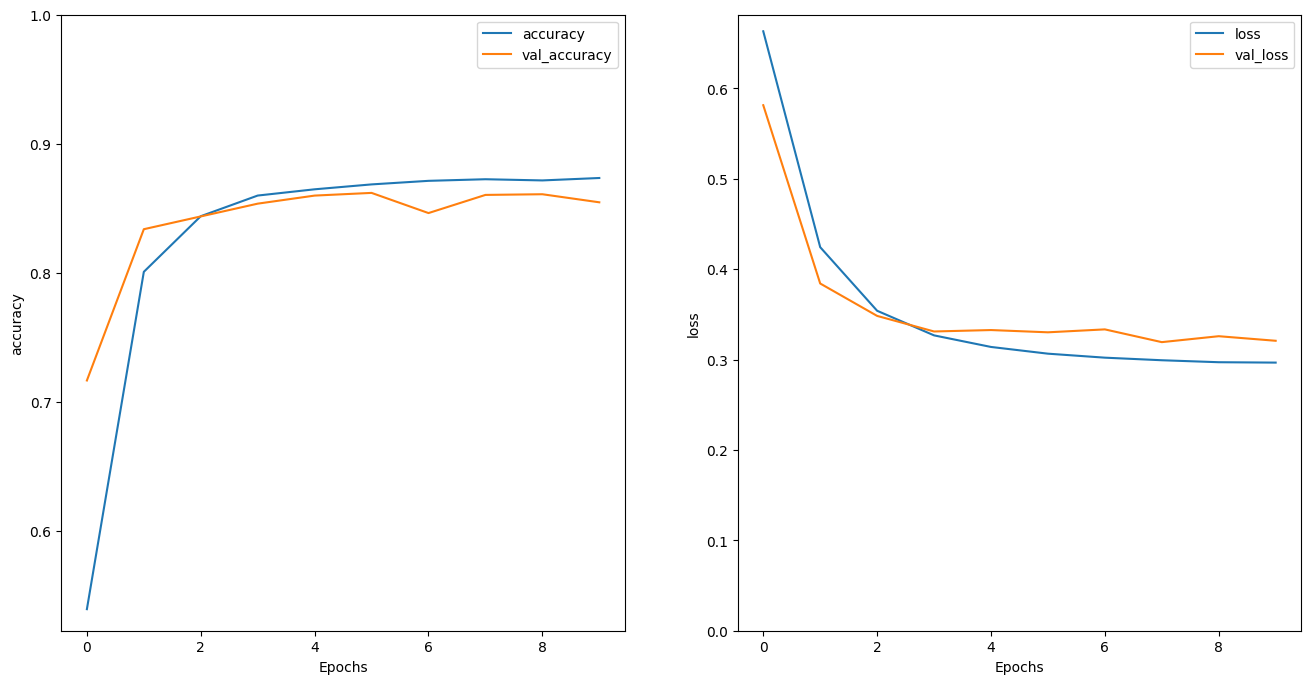

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [19]:
model = tf.keras.Sequential([encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 92s 190ms/step - loss: 0.6206 - accuracy: 0.5950 - val_loss: 0.4365 - val_accuracy: 0.8172
Epoch 2/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3828 - accuracy: 0.8302 - val_loss: 0.3448 - val_accuracy: 0.8552
Epoch 3/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3337 - accuracy: 0.8552 - val_loss: 0.3356 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 51s 131ms/step - loss: 0.3170 - accuracy: 0.8630 - val_loss: 0.3258 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3109 - accuracy: 0.8656 - val_loss: 0.3234 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 52s 133ms/step - loss: 0.3104 - accuracy: 0.8676 - val_loss: 0.3560 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3047 - accuracy: 0.8690 - val_loss: 0.3220 - val_ac

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.3307 - accuracy: 0.8611
Test Loss: 0.3306749165058136
Test Accuracy: 0.8611199855804443


In [22]:
# predict on a sample text without padding.
sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.8021271]]


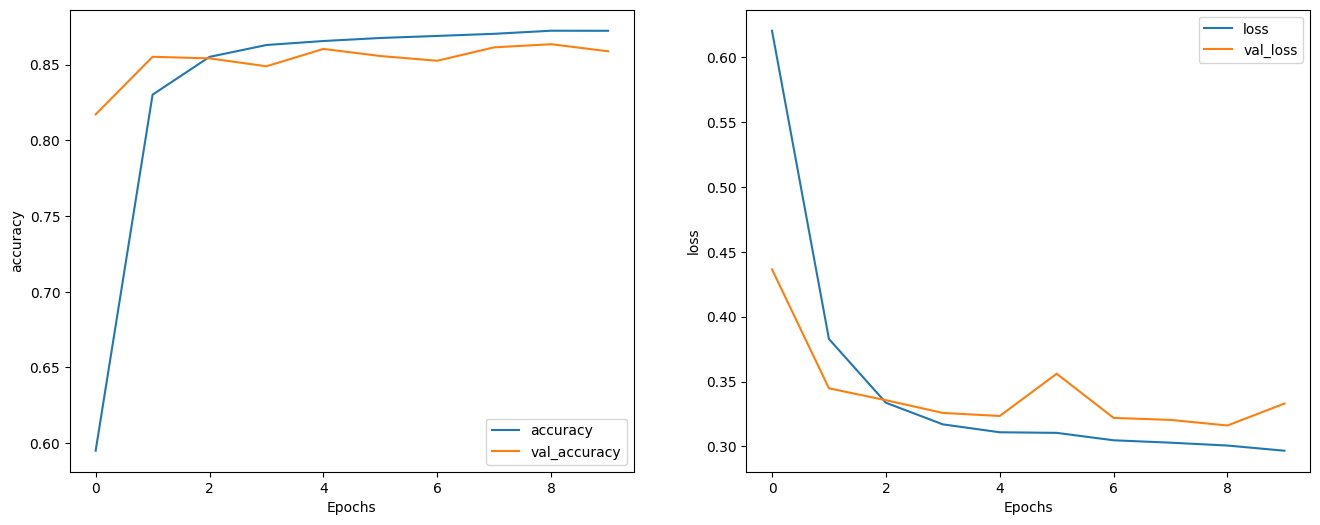

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')